<a href="https://colab.research.google.com/github/hotekagi/gc_assignment/blob/main/I3_TextureSynthesis/I3_TextureSynthesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Texture optimization for example-based synthesis

Vivek Kwatra, Irfan Essa, Aaron Bobick, and Nipun Kwatra. 2005.
Texture optimization for example-based synthesis. ACM Trans. Graph. 24, 3 (July 2005), 795–802.
https://doi.org/10.1145/1073204.1073263

Copyright © 2005 by the Association for Computing Machinery, Inc

## Algorithm 1

```
This is a Python implementation of Algorithm 1 in the paper above.
Code is my own work, but the idea is from the paper.
```

Saving 161.jpg to 161 (3).jpg
texture image size is (64, 64, 3)


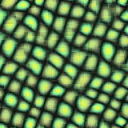

  0%|          | 0/50 [00:00<?, ?it/s]

iter 1: loss:1413.5038248697917
iter 2: loss:1360.6696370442708
iter 3: loss:1289.3813883463542
iter 4: loss:1241.9456380208333
iter 5: loss:1217.5712483723958
iter 6: loss:1201.3018188476562
iter 7: loss:1198.5646362304688
iter 8: loss:1188.4439900716145
iter 9: loss:1177.221659342448
iter 10: loss:1166.0931599934895
iter 11: loss:1162.9005737304688
iter 12: loss:1157.7681477864583
iter 13: loss:1155.6969807942708
iter 14: loss:1150.5244750976562
iter 15: loss:1144.0020345052083
iter 16: loss:1142.710225423177
iter 17: loss:1139.7277018229167
iter 18: loss:1136.054423014323
iter 19: loss:1135.3584594726562
iter 20: loss:1134.379150390625
iter 21: loss:1133.8843383789062
iter 22: loss:1132.629374186198
iter 23: loss:1132.1795247395833
iter 24: loss:1130.591288248698
iter 25: loss:1130.992411295573
iter 26: loss:1130.856465657552
iter 27: loss:1131.3735758463542
iter 28: loss:1130.726338704427
iter 29: loss:1131.095194498698
iter 30: loss:1131.296854654948
iter 31: loss:1130.78232828776

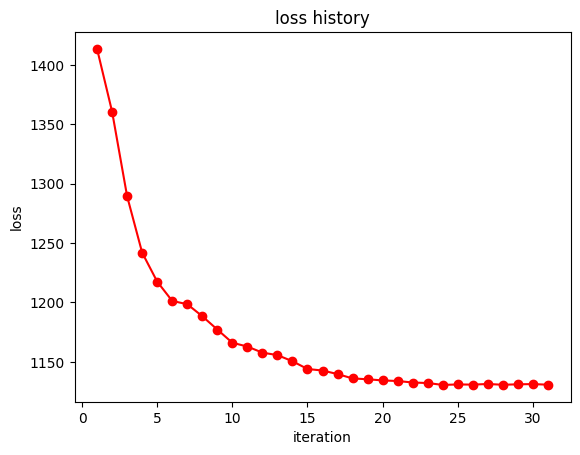

In [4]:
#@markdown **セルを実行して，textureの元画像をアップロードすると処理が始まる**
#@markdown  \\
#@markdown  デモの画像は
#@markdown https://github.com/1iyiwei/texture/blob/master/data/161.jpg
#@markdown より


from datetime import datetime

import cv2
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from PIL import Image
from tqdm.notebook import tqdm

from google.colab import files
uploaded = files.upload()

### variables
#@markdown **パラメータを設定する**

#@markdown 生成する画像の1辺のサイズ
target_width = 128 #@param {type: "integer"}
#@markdown 近傍のサイズ
neighbor_width = 16 #@param {type: "integer"}
#@markdown 最大反復回数
max_iter = 50 #@param {type: "integer"}
#@markdown　ログの詳細表示
debug = True #@param {type: "boolean"}

if len(list(uploaded.keys())) == 0:
    raise Exception("キャンセルしました")

texture = cv2.imread(list(uploaded.keys())[0])
texture = cv2.cvtColor(texture, cv2.COLOR_BGR2RGB)
if debug:
    print("texture image size is", texture.shape)

target = np.random.randint(0, 256, size=(target_width, target_width, 3), dtype=np.uint8)
img_display = display(Image.fromarray(target), display_id=True)

indices = np.arange(0, target_width - neighbor_width + 1, neighbor_width // 4)
x, y = np.meshgrid(indices, indices)
target_anchors = np.column_stack((y.ravel(), x.ravel()))

texture_anchors = np.zeros((len(target_anchors), 2), dtype=int)
texture_anchors[:, 0] = np.random.randint(
    0, texture.shape[0] - neighbor_width, size=len(target_anchors)
)
texture_anchors[:, 1] = np.random.randint(
    0, texture.shape[1] - neighbor_width, size=len(target_anchors)
)


loss_history = []

for iter in tqdm(range(max_iter)):
    # update target to argmin(E(target, texture))
    ref_for_pixel = [[] for _ in range(target_width**2)]

    for target_anchor, texture_anchor in zip(target_anchors, texture_anchors):
        y, x = target_anchor
        yy, xx = texture_anchor
        for i in range(neighbor_width):
            for j in range(neighbor_width):
                ref_for_pixel[(y + i) * target_width + (x + j)].append(
                    texture[yy + i, xx + j]
                )

    loss = 0
    for y in range(len(target)):
        for x in range(len(target)):
            target[y, x] = np.mean(ref_for_pixel[y * target_width + x], axis=0)
            loss += np.sum((ref_for_pixel[y * target_width + x] - target[y, x]) ** 2)

    mse = loss / (target.shape[0] * target.shape[1]) / 3
    if debug:
        print(f"iter {iter+1}: loss:{mse}")
    loss_history.append(mse)
    img_display.update(Image.fromarray(target))

    # update texture reference points
    texture_anchors_prev = texture_anchors.copy()

    for i, target_anchor in enumerate(target_anchors):
        y, x = target_anchor
        result = cv2.matchTemplate(
            texture,
            target[y : y + neighbor_width, x : x + neighbor_width, :],
            method=cv2.TM_SQDIFF,
        )
        _, _, min_loc, _ = cv2.minMaxLoc(result)
        texture_anchors[i] = np.array([min_loc[1], min_loc[0]])

    if np.all(texture_anchors == texture_anchors_prev):
        break


now = datetime.now()
now = now.strftime("%Y%m%d%H%M%S")
Image.fromarray(target).save(f"synthesized_texture{now}.png")

plt.plot(range(1, len(loss_history) + 1), loss_history, "ro-")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.title("loss history")
plt.show()

## Algorithm 2